# Recurrent Neural Network - LSTM


## Parte 1 - Preprocessamento de Dados

### Importar as bibliotecas

In [1]:
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import pandas as pd
import os

### Importar a base de dados

In [2]:
# Foi utilizada a base de dados de cotação de ações da Petrobras (PETR4)
# O período analisado vai de 23/05/2020 a 23/05/2023
# A série temporal foi dividida em treino (30%) e teste (70%)

In [3]:
PETR4_data = pd.read_csv('PETR4.csv')

In [4]:
PETR4_data_train = PETR4_data.iloc[1:249, 0:2].values

In [5]:
PETR4_data_test= PETR4_data.iloc[249:747, 0:2].values

In [6]:
training_set = PETR4_data.iloc[0:249, 1:2].values

In [7]:
test_set = PETR4_data.iloc[249:747,1:2]

### Parâmetros para esta análise

In [8]:
pwindow = 15
pepochs3 = 100
pbatch2 = 64

units1 = 50
units2 = 60
units3 = 30

### Normalização

In [9]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [10]:
window = pwindow
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [11]:
X_train.shape

(234, 15)

Shape de input da lstm = (batch_size, timesteps, features)

In [12]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [13]:
X_train.shape

(234, 15, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [15]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = units1, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = units2, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = units3))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 15, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 60)            26640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 60)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                10920     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

### Treinamento

In [16]:
history = regressor.fit(X_train, y_train, epochs = pepochs3, batch_size = pbatch2)

Epoch 1/100
4/4 [==============================] - 0s 16ms/step - loss: 0.1092
Epoch 2/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0417
Epoch 3/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0327
Epoch 4/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0275
Epoch 5/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0232
Epoch 6/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0222
Epoch 7/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0201
Epoch 8/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0218
Epoch 9/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0203
Epoch 10/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0213
Epoch 11/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0211
Epoch 12/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0178
Epoch 13/100
4/4 [==============================]

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [17]:
dataset_test = test_set
PETR4_data_train = pd.DataFrame(PETR4_data_train)
PETR4_data_test = pd.DataFrame(PETR4_data_test)

### Construir a estrutura para teste

In [18]:
dataset_total = pd.concat((PETR4_data_train.iloc[:,1], PETR4_data_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [19]:
predicted_PETR4 = regressor.predict(X_test)
predicted_PETR4 = sc.inverse_transform(predicted_PETR4)

### Visualizar os resultados de treino e teste

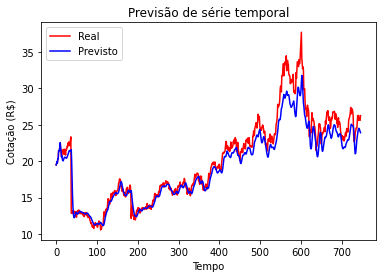

In [20]:
allTargetData = np.vstack((training_set, dataset_test))
training_predicted_PETR4 = regressor.predict(X_train)
training_predicted_PETR4 = sc.inverse_transform(training_predicted_PETR4)
allForecastedData = np.vstack((training_set[0:window], training_predicted_PETR4, predicted_PETR4))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.savefig('predictions_training_test_25_50_32.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [21]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(dataset_test, predicted_PETR4))
print('RMSE:', rmse)

RMSE: 1.9064291028692852


In [22]:
mse = mean_squared_error(dataset_test, predicted_PETR4)
print('MSE:',mse)

MSE: 3.634471924266988


In [23]:
mape = np.mean(np.abs((dataset_test-predicted_PETR4) /dataset_test)) * 100
print('MAPE:',mape.iloc[0], '%')

MAPE: 5.867444738715124 %


In [24]:
from sklearn.metrics import r2_score
r2 = r2_score(dataset_test,predicted_PETR4)
print('R2:', r2)

R2: 0.8521014633533475


In [25]:
adj_r2 = (1 - (1 - r2) * ((predicted_PETR4.shape[0] - 1) / 
          (predicted_PETR4.shape[0] - predicted_PETR4.shape[1] - 1)))
print('R2Adj:',adj_r2)

R2Adj: 0.8518032808197857


In [26]:
results = np.array([units1,units2,units3,rmse,mse,mape.iloc[0],r2,adj_r2]) 

In [27]:
print(results)

[50.         60.         30.          1.9064291   3.63447192  5.86744474
  0.85210146  0.85180328]


### Parâmetros para esta análise

In [28]:
pwindow = 15
pepochs3 = 100
pbatch2 = 64

units1 = 50
units2 = 60
units3 = 50

### Normalização

In [29]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [30]:
window = pwindow
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [31]:
X_train.shape

(234, 15)

Shape de input da lstm = (batch_size, timesteps, features)

In [32]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [33]:
X_train.shape

(234, 15, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [34]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [35]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = units1, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = units2, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = units3))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()  

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 15, 50)            10400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 50)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 15, 60)            26640     
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 60)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                22200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

### Treinamento

In [36]:
history = regressor.fit(X_train, y_train, epochs = pepochs3, batch_size = pbatch2)

Epoch 1/100
4/4 [==============================] - 0s 17ms/step - loss: 0.1163
Epoch 2/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0348
Epoch 3/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0385
Epoch 4/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0247
Epoch 5/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0267
Epoch 6/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0266
Epoch 7/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0201
Epoch 8/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0233
Epoch 9/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0212
Epoch 10/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0205
Epoch 11/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0199
Epoch 12/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0189
Epoch 13/100
4/4 [==============================]

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [37]:
dataset_test = test_set
PETR4_data_train = pd.DataFrame(PETR4_data_train)
PETR4_data_test = pd.DataFrame(PETR4_data_test)

### Construir a estrutura para teste

In [38]:
dataset_total = pd.concat((PETR4_data_train.iloc[:,1], PETR4_data_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [39]:
predicted_PETR4 = regressor.predict(X_test)
predicted_PETR4 = sc.inverse_transform(predicted_PETR4)

### Visualizar os resultados de treino e teste

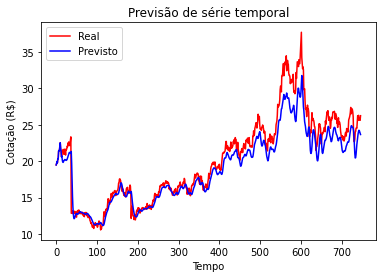

In [40]:
allTargetData = np.vstack((training_set, dataset_test))
training_predicted_PETR4 = regressor.predict(X_train)
training_predicted_PETR4 = sc.inverse_transform(training_predicted_PETR4)
allForecastedData = np.vstack((training_set[0:window], training_predicted_PETR4, predicted_PETR4))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.savefig('predictions_training_test_25_50_32.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [41]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(dataset_test, predicted_PETR4))
print('RMSE:', rmse)

RMSE: 2.186859436045316


In [42]:
mse = mean_squared_error(dataset_test, predicted_PETR4)
print('MSE:',mse)

MSE: 4.782354193020437


In [43]:
mape = np.mean(np.abs((dataset_test-predicted_PETR4) /dataset_test)) * 100
print('MAPE:',mape.iloc[0], '%')

MAPE: 6.986826736473032 %


In [44]:
from sklearn.metrics import r2_score
r2 = r2_score(dataset_test,predicted_PETR4)
print('R2:', r2)

R2: 0.8053903836342451


In [45]:
adj_r2 = (1 - (1 - r2) * ((predicted_PETR4.shape[0] - 1) / 
          (predicted_PETR4.shape[0] - predicted_PETR4.shape[1] - 1)))
print('R2Adj:',adj_r2)

R2Adj: 0.8049980255367335


In [46]:
# results = np.array([units1,units2,units3,rmse,mse,mape.iloc[0],r2,adj_r2]) 

In [47]:
data = pd.array([units1,units2,units3,rmse,mse,mape.iloc[0],r2,adj_r2])

In [48]:
results = np.column_stack((results, data))

In [49]:
print(results)

[[50.         50.        ]
 [60.         60.        ]
 [30.         50.        ]
 [ 1.9064291   2.18685944]
 [ 3.63447192  4.78235419]
 [ 5.86744474  6.98682674]
 [ 0.85210146  0.80539038]
 [ 0.85180328  0.80499803]]


### Parâmetros para esta análise

In [50]:
pwindow = 15
pepochs3 = 100
pbatch2 = 64

units1 = 50
units2 = 60
units3 = 70

### Normalização

In [51]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [52]:
window = pwindow
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [53]:
X_train.shape

(234, 15)

Shape de input da lstm = (batch_size, timesteps, features)

In [54]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [55]:
X_train.shape

(234, 15, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [56]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [57]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = units1, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = units2, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = units3))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()  

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 15, 50)            10400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 50)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 15, 60)            26640     
_________________________________________________________________
dropout_7 (Dropout)          (None, 15, 60)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 70)                36680     
_________________________________________________________________
dropout_8 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

### Treinamento

In [58]:
history = regressor.fit(X_train, y_train, epochs = pepochs3, batch_size = pbatch2)

Epoch 1/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0915
Epoch 2/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0312
Epoch 3/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0275
Epoch 4/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0255
Epoch 5/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0248
Epoch 6/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0205
Epoch 7/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0233
Epoch 8/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0213
Epoch 9/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0199
Epoch 10/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0184
Epoch 11/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0195
Epoch 12/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0192
Epoch 13/100
4/4 [==============================]

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [59]:
dataset_test = test_set
PETR4_data_train = pd.DataFrame(PETR4_data_train)
PETR4_data_test = pd.DataFrame(PETR4_data_test)

### Construir a estrutura para teste

In [60]:
dataset_total = pd.concat((PETR4_data_train.iloc[:,1], PETR4_data_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [61]:
predicted_PETR4 = regressor.predict(X_test)
predicted_PETR4 = sc.inverse_transform(predicted_PETR4)

### Visualizar os resultados de treino e teste

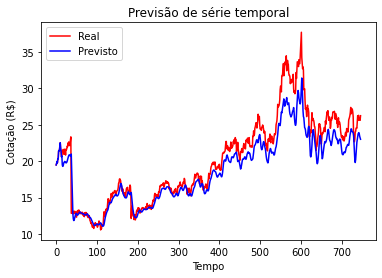

In [62]:
allTargetData = np.vstack((training_set, dataset_test))
training_predicted_PETR4 = regressor.predict(X_train)
training_predicted_PETR4 = sc.inverse_transform(training_predicted_PETR4)
allForecastedData = np.vstack((training_set[0:window], training_predicted_PETR4, predicted_PETR4))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.savefig('predictions_training_test_25_50_32.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [63]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(dataset_test, predicted_PETR4))
print('RMSE:', rmse)

RMSE: 2.510694001448556


In [64]:
mse = mean_squared_error(dataset_test, predicted_PETR4)
print('MSE:',mse)

MSE: 6.303584368909761


In [65]:
mape = np.mean(np.abs((dataset_test-predicted_PETR4) /dataset_test)) * 100
print('MAPE:',mape.iloc[0], '%')

MAPE: 8.226426488205 %


In [66]:
from sklearn.metrics import r2_score
r2 = r2_score(dataset_test,predicted_PETR4)
print('R2:', r2)

R2: 0.7434865578227038


In [67]:
adj_r2 = (1 - (1 - r2) * ((predicted_PETR4.shape[0] - 1) / 
          (predicted_PETR4.shape[0] - predicted_PETR4.shape[1] - 1)))
print('R2Adj:',adj_r2)

R2Adj: 0.7429693936247657


In [68]:
# results = np.array([units1,units2,units3,rmse,mse,mape.iloc[0],r2,adj_r2]) 

In [69]:
data = pd.array([units1,units2,units3,rmse,mse,mape.iloc[0],r2,adj_r2])

In [70]:
results = np.column_stack((results, data))

In [71]:
print(results)

[[50.         50.         50.        ]
 [60.         60.         60.        ]
 [30.         50.         70.        ]
 [ 1.9064291   2.18685944  2.510694  ]
 [ 3.63447192  4.78235419  6.30358437]
 [ 5.86744474  6.98682674  8.22642649]
 [ 0.85210146  0.80539038  0.74348656]
 [ 0.85180328  0.80499803  0.74296939]]


### Parâmetros para esta análise

In [72]:
pwindow = 15
pepochs3 = 100
pbatch2 = 64

units1 = 50
units2 = 80
units3 = 30

### Normalização

In [73]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [74]:
window = pwindow
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [75]:
X_train.shape

(234, 15)

Shape de input da lstm = (batch_size, timesteps, features)

In [76]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [77]:
X_train.shape

(234, 15, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [78]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [79]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = units1, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = units2, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = units3))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()  

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 15, 50)            10400     
_________________________________________________________________
dropout_9 (Dropout)          (None, 15, 50)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 15, 80)            41920     
_________________________________________________________________
dropout_10 (Dropout)         (None, 15, 80)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 30)                13320     
_________________________________________________________________
dropout_11 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

### Treinamento

In [80]:
history = regressor.fit(X_train, y_train, epochs = pepochs3, batch_size = pbatch2)

Epoch 1/100
4/4 [==============================] - 0s 19ms/step - loss: 0.0983
Epoch 2/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0305
Epoch 3/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0340
Epoch 4/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0225
Epoch 5/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0241
Epoch 6/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0231
Epoch 7/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0211
Epoch 8/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0201
Epoch 9/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0191
Epoch 10/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0195
Epoch 11/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0191
Epoch 12/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0196
Epoch 13/100
4/4 [==============================]

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [81]:
dataset_test = test_set
PETR4_data_train = pd.DataFrame(PETR4_data_train)
PETR4_data_test = pd.DataFrame(PETR4_data_test)

### Construir a estrutura para teste

In [82]:
dataset_total = pd.concat((PETR4_data_train.iloc[:,1], PETR4_data_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [83]:
predicted_PETR4 = regressor.predict(X_test)
predicted_PETR4 = sc.inverse_transform(predicted_PETR4)

### Visualizar os resultados de treino e teste

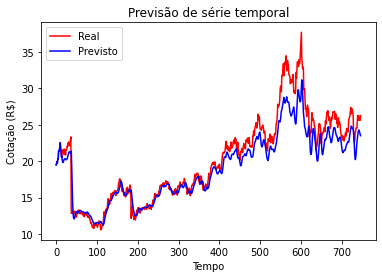

In [84]:
allTargetData = np.vstack((training_set, dataset_test))
training_predicted_PETR4 = regressor.predict(X_train)
training_predicted_PETR4 = sc.inverse_transform(training_predicted_PETR4)
allForecastedData = np.vstack((training_set[0:window], training_predicted_PETR4, predicted_PETR4))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.savefig('predictions_training_test_25_50_32.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [85]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(dataset_test, predicted_PETR4))
print('RMSE:', rmse)

RMSE: 2.2836942219331244


In [86]:
mse = mean_squared_error(dataset_test, predicted_PETR4)
print('MSE:',mse)

MSE: 5.2152592992907385


In [87]:
mape = np.mean(np.abs((dataset_test-predicted_PETR4) /dataset_test)) * 100
print('MAPE:',mape.iloc[0], '%')

MAPE: 6.954808791198144 %


In [88]:
from sklearn.metrics import r2_score
r2 = r2_score(dataset_test,predicted_PETR4)
print('R2:', r2)

R2: 0.7877740605319132


In [89]:
adj_r2 = (1 - (1 - r2) * ((predicted_PETR4.shape[0] - 1) / 
          (predicted_PETR4.shape[0] - predicted_PETR4.shape[1] - 1)))
print('R2Adj:',adj_r2)

R2Adj: 0.7873461856539534


In [90]:
# results = np.array([units1,units2,units3,rmse,mse,mape.iloc[0],r2,adj_r2]) 

In [91]:
data = pd.array([units1,units2,units3,rmse,mse,mape.iloc[0],r2,adj_r2])

In [92]:
results = np.column_stack((results, data))

In [93]:
print(results)

[[50.         50.         50.         50.        ]
 [60.         60.         60.         80.        ]
 [30.         50.         70.         30.        ]
 [ 1.9064291   2.18685944  2.510694    2.28369422]
 [ 3.63447192  4.78235419  6.30358437  5.2152593 ]
 [ 5.86744474  6.98682674  8.22642649  6.95480879]
 [ 0.85210146  0.80539038  0.74348656  0.78777406]
 [ 0.85180328  0.80499803  0.74296939  0.78734619]]


### Parâmetros para esta análise

In [94]:
pwindow = 15
pepochs3 = 100
pbatch2 = 64

units1 = 50
units2 = 80
units3 = 50

### Normalização

In [95]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [96]:
window = pwindow
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [97]:
X_train.shape

(234, 15)

Shape de input da lstm = (batch_size, timesteps, features)

In [98]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [99]:
X_train.shape

(234, 15, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [100]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [101]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = units1, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = units2, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = units3))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()  

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 15, 50)            10400     
_________________________________________________________________
dropout_12 (Dropout)         (None, 15, 50)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 15, 80)            41920     
_________________________________________________________________
dropout_13 (Dropout)         (None, 15, 80)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 50)                26200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

### Treinamento

In [102]:
history = regressor.fit(X_train, y_train, epochs = pepochs3, batch_size = pbatch2)

Epoch 1/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0800
Epoch 2/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0336
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0259
Epoch 4/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0271
Epoch 5/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0230
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0184
Epoch 7/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0232
Epoch 8/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0171
Epoch 9/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0194
Epoch 10/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0200
Epoch 11/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0183
Epoch 12/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0170
Epoch 13/100
4/4 [==============================]

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [103]:
dataset_test = test_set
PETR4_data_train = pd.DataFrame(PETR4_data_train)
PETR4_data_test = pd.DataFrame(PETR4_data_test)

### Construir a estrutura para teste

In [104]:
dataset_total = pd.concat((PETR4_data_train.iloc[:,1], PETR4_data_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [105]:
predicted_PETR4 = regressor.predict(X_test)
predicted_PETR4 = sc.inverse_transform(predicted_PETR4)

### Visualizar os resultados de treino e teste

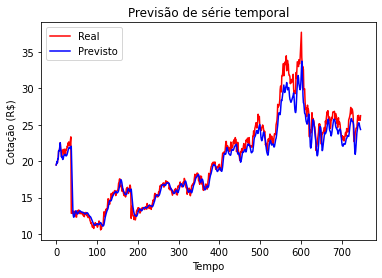

In [106]:
allTargetData = np.vstack((training_set, dataset_test))
training_predicted_PETR4 = regressor.predict(X_train)
training_predicted_PETR4 = sc.inverse_transform(training_predicted_PETR4)
allForecastedData = np.vstack((training_set[0:window], training_predicted_PETR4, predicted_PETR4))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.savefig('predictions_training_test_25_50_32.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [107]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(dataset_test, predicted_PETR4))
print('RMSE:', rmse)

RMSE: 1.462124842321957


In [108]:
mse = mean_squared_error(dataset_test, predicted_PETR4)
print('MSE:',mse)

MSE: 2.137809054535008


In [109]:
mape = np.mean(np.abs((dataset_test-predicted_PETR4) /dataset_test)) * 100
print('MAPE:',mape.iloc[0], '%')

MAPE: 4.326610152414612 %


In [110]:
from sklearn.metrics import r2_score
r2 = r2_score(dataset_test,predicted_PETR4)
print('R2:', r2)

R2: 0.913005565214413


In [111]:
adj_r2 = (1 - (1 - r2) * ((predicted_PETR4.shape[0] - 1) / 
          (predicted_PETR4.shape[0] - predicted_PETR4.shape[1] - 1)))
print('R2Adj:',adj_r2)

R2Adj: 0.9128301732087969


In [112]:
# results = np.array([units1,units2,units3,rmse,mse,mape.iloc[0],r2,adj_r2]) 

In [113]:
data = pd.array([units1,units2,units3,rmse,mse,mape.iloc[0],r2,adj_r2])

In [114]:
results = np.column_stack((results, data))

In [115]:
print(results)

[[50.         50.         50.         50.         50.        ]
 [60.         60.         60.         80.         80.        ]
 [30.         50.         70.         30.         50.        ]
 [ 1.9064291   2.18685944  2.510694    2.28369422  1.46212484]
 [ 3.63447192  4.78235419  6.30358437  5.2152593   2.13780905]
 [ 5.86744474  6.98682674  8.22642649  6.95480879  4.32661015]
 [ 0.85210146  0.80539038  0.74348656  0.78777406  0.91300557]
 [ 0.85180328  0.80499803  0.74296939  0.78734619  0.91283017]]


### Parâmetros para esta análise

In [116]:
pwindow = 15
pepochs3 = 100
pbatch2 = 64

units1 = 50
units2 = 80
units3 = 70

### Normalização

In [117]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [118]:
window = pwindow
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [119]:
X_train.shape

(234, 15)

Shape de input da lstm = (batch_size, timesteps, features)

In [120]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [121]:
X_train.shape

(234, 15, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [122]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [123]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = units1, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = units2, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = units3))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()  

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 15, 50)            10400     
_________________________________________________________________
dropout_15 (Dropout)         (None, 15, 50)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 15, 80)            41920     
_________________________________________________________________
dropout_16 (Dropout)         (None, 15, 80)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 70)                42280     
_________________________________________________________________
dropout_17 (Dropout)         (None, 70)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

### Treinamento

In [124]:
history = regressor.fit(X_train, y_train, epochs = pepochs3, batch_size = pbatch2)

Epoch 1/100
4/4 [==============================] - 0s 17ms/step - loss: 0.1151
Epoch 2/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0334
Epoch 3/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0302
Epoch 4/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0278
Epoch 5/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0272
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0223
Epoch 7/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0232
Epoch 8/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0185
Epoch 9/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0211
Epoch 10/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0193
Epoch 11/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0187
Epoch 12/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0196
Epoch 13/100
4/4 [==============================]

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [125]:
dataset_test = test_set
PETR4_data_train = pd.DataFrame(PETR4_data_train)
PETR4_data_test = pd.DataFrame(PETR4_data_test)

### Construir a estrutura para teste

In [126]:
dataset_total = pd.concat((PETR4_data_train.iloc[:,1], PETR4_data_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [127]:
predicted_PETR4 = regressor.predict(X_test)
predicted_PETR4 = sc.inverse_transform(predicted_PETR4)

### Visualizar os resultados de treino e teste

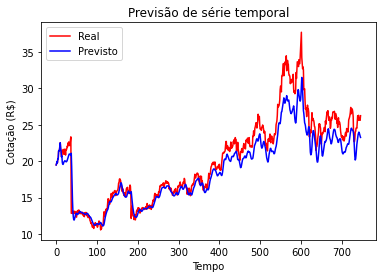

In [128]:
allTargetData = np.vstack((training_set, dataset_test))
training_predicted_PETR4 = regressor.predict(X_train)
training_predicted_PETR4 = sc.inverse_transform(training_predicted_PETR4)
allForecastedData = np.vstack((training_set[0:window], training_predicted_PETR4, predicted_PETR4))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.savefig('predictions_training_test_25_50_32.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [129]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(dataset_test, predicted_PETR4))
print('RMSE:', rmse)

RMSE: 2.366466552744614


In [130]:
mse = mean_squared_error(dataset_test, predicted_PETR4)
print('MSE:',mse)

MSE: 5.600163945258976


In [131]:
mape = np.mean(np.abs((dataset_test-predicted_PETR4) /dataset_test)) * 100
print('MAPE:',mape.iloc[0], '%')

MAPE: 7.65246644759088 %


In [132]:
from sklearn.metrics import r2_score
r2 = r2_score(dataset_test,predicted_PETR4)
print('R2:', r2)

R2: 0.7721110329797932


In [133]:
adj_r2 = (1 - (1 - r2) * ((predicted_PETR4.shape[0] - 1) / 
          (predicted_PETR4.shape[0] - predicted_PETR4.shape[1] - 1)))
print('R2Adj:',adj_r2)

R2Adj: 0.7716515794172525


In [134]:
# results = np.array([units1,units2,units3,rmse,mse,mape.iloc[0],r2,adj_r2]) 

In [135]:
data = pd.array([units1,units2,units3,rmse,mse,mape.iloc[0],r2,adj_r2])

In [136]:
results = np.column_stack((results, data))

In [137]:
print(results)

[[50.         50.         50.         50.         50.         50.        ]
 [60.         60.         60.         80.         80.         80.        ]
 [30.         50.         70.         30.         50.         70.        ]
 [ 1.9064291   2.18685944  2.510694    2.28369422  1.46212484  2.36646655]
 [ 3.63447192  4.78235419  6.30358437  5.2152593   2.13780905  5.60016395]
 [ 5.86744474  6.98682674  8.22642649  6.95480879  4.32661015  7.65246645]
 [ 0.85210146  0.80539038  0.74348656  0.78777406  0.91300557  0.77211103]
 [ 0.85180328  0.80499803  0.74296939  0.78734619  0.91283017  0.77165158]]


### Parâmetros para esta análise

In [138]:
pwindow = 15
pepochs3 = 100
pbatch2 = 64

units1 = 50
units2 = 100
units3 = 30

### Normalização

In [139]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [140]:
window = pwindow
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [141]:
X_train.shape

(234, 15)

Shape de input da lstm = (batch_size, timesteps, features)

In [142]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [143]:
X_train.shape

(234, 15, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [144]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [145]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = units1, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = units2, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = units3))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()  

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 15, 50)            10400     
_________________________________________________________________
dropout_18 (Dropout)         (None, 15, 50)            0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 15, 100)           60400     
_________________________________________________________________
dropout_19 (Dropout)         (None, 15, 100)           0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 30)                15720     
_________________________________________________________________
dropout_20 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

### Treinamento

In [146]:
history = regressor.fit(X_train, y_train, epochs = pepochs3, batch_size = pbatch2)

Epoch 1/100
4/4 [==============================] - 0s 19ms/step - loss: 0.1055
Epoch 2/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0324
Epoch 3/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0319
Epoch 4/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0242
Epoch 5/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0273
Epoch 6/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0231
Epoch 7/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0226
Epoch 8/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0194
Epoch 9/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0193
Epoch 10/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0190
Epoch 11/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0181
Epoch 12/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0178
Epoch 13/100
4/4 [==============================]

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [147]:
dataset_test = test_set
PETR4_data_train = pd.DataFrame(PETR4_data_train)
PETR4_data_test = pd.DataFrame(PETR4_data_test)

### Construir a estrutura para teste

In [148]:
dataset_total = pd.concat((PETR4_data_train.iloc[:,1], PETR4_data_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [149]:
predicted_PETR4 = regressor.predict(X_test)
predicted_PETR4 = sc.inverse_transform(predicted_PETR4)

### Visualizar os resultados de treino e teste

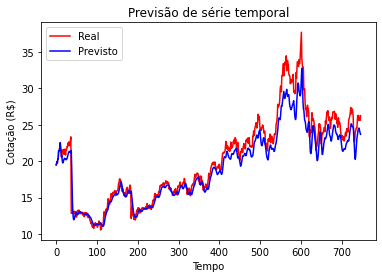

In [150]:
allTargetData = np.vstack((training_set, dataset_test))
training_predicted_PETR4 = regressor.predict(X_train)
training_predicted_PETR4 = sc.inverse_transform(training_predicted_PETR4)
allForecastedData = np.vstack((training_set[0:window], training_predicted_PETR4, predicted_PETR4))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.savefig('predictions_training_test_25_50_32.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [151]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(dataset_test, predicted_PETR4))
print('RMSE:', rmse)

RMSE: 1.9896046211878748


In [152]:
mse = mean_squared_error(dataset_test, predicted_PETR4)
print('MSE:',mse)

MSE: 3.958526548652147


In [153]:
mape = np.mean(np.abs((dataset_test-predicted_PETR4) /dataset_test)) * 100
print('MAPE:',mape.iloc[0], '%')

MAPE: 6.330454142845119 %


In [154]:
from sklearn.metrics import r2_score
r2 = r2_score(dataset_test,predicted_PETR4)
print('R2:', r2)

R2: 0.8389146219802883


In [155]:
adj_r2 = (1 - (1 - r2) * ((predicted_PETR4.shape[0] - 1) / 
          (predicted_PETR4.shape[0] - predicted_PETR4.shape[1] - 1)))
print('R2Adj:',adj_r2)

R2Adj: 0.8385898530729905


In [156]:
# results = np.array([units1,units2,units3,rmse,mse,mape.iloc[0],r2,adj_r2]) 

In [157]:
data = pd.array([units1,units2,units3,rmse,mse,mape.iloc[0],r2,adj_r2])

In [158]:
results = np.column_stack((results, data))

In [159]:
print(results)

[[ 50.          50.          50.          50.          50.
   50.          50.        ]
 [ 60.          60.          60.          80.          80.
   80.         100.        ]
 [ 30.          50.          70.          30.          50.
   70.          30.        ]
 [  1.9064291    2.18685944   2.510694     2.28369422   1.46212484
    2.36646655   1.98960462]
 [  3.63447192   4.78235419   6.30358437   5.2152593    2.13780905
    5.60016395   3.95852655]
 [  5.86744474   6.98682674   8.22642649   6.95480879   4.32661015
    7.65246645   6.33045414]
 [  0.85210146   0.80539038   0.74348656   0.78777406   0.91300557
    0.77211103   0.83891462]
 [  0.85180328   0.80499803   0.74296939   0.78734619   0.91283017
    0.77165158   0.83858985]]


### Parâmetros para esta análise

In [160]:
pwindow = 15
pepochs3 = 100
pbatch2 = 64

units1 = 50
units2 = 100
units3 = 50

### Normalização

In [161]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [162]:
window = pwindow
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [163]:
X_train.shape

(234, 15)

Shape de input da lstm = (batch_size, timesteps, features)

In [164]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [165]:
X_train.shape

(234, 15, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [166]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [167]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = units1, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = units2, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = units3))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()  

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 15, 50)            10400     
_________________________________________________________________
dropout_21 (Dropout)         (None, 15, 50)            0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 15, 100)           60400     
_________________________________________________________________
dropout_22 (Dropout)         (None, 15, 100)           0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_23 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

### Treinamento

In [168]:
history = regressor.fit(X_train, y_train, epochs = pepochs3, batch_size = pbatch2)

Epoch 1/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0880
Epoch 2/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0321
Epoch 3/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0209
Epoch 4/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0255
Epoch 5/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0243
Epoch 6/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0201
Epoch 7/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0191
Epoch 8/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0179
Epoch 9/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0165
Epoch 10/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0197
Epoch 11/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0175
Epoch 12/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0177
Epoch 13/100
4/4 [==============================]

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [169]:
dataset_test = test_set
PETR4_data_train = pd.DataFrame(PETR4_data_train)
PETR4_data_test = pd.DataFrame(PETR4_data_test)

### Construir a estrutura para teste

In [170]:
dataset_total = pd.concat((PETR4_data_train.iloc[:,1], PETR4_data_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [171]:
predicted_PETR4 = regressor.predict(X_test)
predicted_PETR4 = sc.inverse_transform(predicted_PETR4)

### Visualizar os resultados de treino e teste

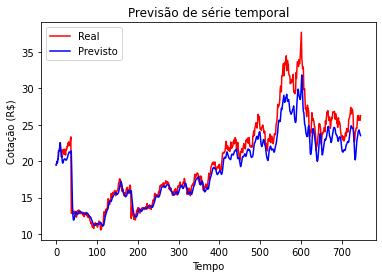

In [172]:
allTargetData = np.vstack((training_set, dataset_test))
training_predicted_PETR4 = regressor.predict(X_train)
training_predicted_PETR4 = sc.inverse_transform(training_predicted_PETR4)
allForecastedData = np.vstack((training_set[0:window], training_predicted_PETR4, predicted_PETR4))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.savefig('predictions_training_test_25_50_32.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [173]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(dataset_test, predicted_PETR4))
print('RMSE:', rmse)

RMSE: 2.2059715868719385


In [174]:
mse = mean_squared_error(dataset_test, predicted_PETR4)
print('MSE:',mse)

MSE: 4.866310642086299


In [175]:
mape = np.mean(np.abs((dataset_test-predicted_PETR4) /dataset_test)) * 100
print('MAPE:',mape.iloc[0], '%')

MAPE: 6.855546076898526 %


In [176]:
from sklearn.metrics import r2_score
r2 = r2_score(dataset_test,predicted_PETR4)
print('R2:', r2)

R2: 0.8019739214307589


In [177]:
adj_r2 = (1 - (1 - r2) * ((predicted_PETR4.shape[0] - 1) / 
          (predicted_PETR4.shape[0] - predicted_PETR4.shape[1] - 1)))
print('R2Adj:',adj_r2)

R2Adj: 0.8015746753046112


In [178]:
# results = np.array([units1,units2,units3,rmse,mse,mape.iloc[0],r2,adj_r2]) 

In [179]:
data = pd.array([units1,units2,units3,rmse,mse,mape.iloc[0],r2,adj_r2])

In [180]:
results = np.column_stack((results, data))

In [181]:
print(results)

[[ 50.          50.          50.          50.          50.
   50.          50.          50.        ]
 [ 60.          60.          60.          80.          80.
   80.         100.         100.        ]
 [ 30.          50.          70.          30.          50.
   70.          30.          50.        ]
 [  1.9064291    2.18685944   2.510694     2.28369422   1.46212484
    2.36646655   1.98960462   2.20597159]
 [  3.63447192   4.78235419   6.30358437   5.2152593    2.13780905
    5.60016395   3.95852655   4.86631064]
 [  5.86744474   6.98682674   8.22642649   6.95480879   4.32661015
    7.65246645   6.33045414   6.85554608]
 [  0.85210146   0.80539038   0.74348656   0.78777406   0.91300557
    0.77211103   0.83891462   0.80197392]
 [  0.85180328   0.80499803   0.74296939   0.78734619   0.91283017
    0.77165158   0.83858985   0.80157468]]


### Parâmetros para esta análise

In [182]:
pwindow = 15
pepochs3 = 100
pbatch2 = 64

units1 = 50
units2 = 100
units3 = 70

### Normalização

In [183]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [184]:
window = pwindow
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [185]:
X_train.shape

(234, 15)

Shape de input da lstm = (batch_size, timesteps, features)

In [186]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [187]:
X_train.shape

(234, 15, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [188]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [189]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = units1, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = units2, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = units3))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()  

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 15, 50)            10400     
_________________________________________________________________
dropout_24 (Dropout)         (None, 15, 50)            0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 15, 100)           60400     
_________________________________________________________________
dropout_25 (Dropout)         (None, 15, 100)           0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 70)                47880     
_________________________________________________________________
dropout_26 (Dropout)         (None, 70)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

### Treinamento

In [190]:
history = regressor.fit(X_train, y_train, epochs = pepochs3, batch_size = pbatch2)

Epoch 1/100
4/4 [==============================] - 0s 21ms/step - loss: 0.0937
Epoch 2/100
4/4 [==============================] - 0s 19ms/step - loss: 0.0332
Epoch 3/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0240
Epoch 4/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0258
Epoch 5/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0196
Epoch 6/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0213
Epoch 7/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0178
Epoch 8/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0222
Epoch 9/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0189
Epoch 10/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0163
Epoch 11/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0181
Epoch 12/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0176
Epoch 13/100
4/4 [==============================]

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [191]:
dataset_test = test_set
PETR4_data_train = pd.DataFrame(PETR4_data_train)
PETR4_data_test = pd.DataFrame(PETR4_data_test)

### Construir a estrutura para teste

In [192]:
dataset_total = pd.concat((PETR4_data_train.iloc[:,1], PETR4_data_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [193]:
predicted_PETR4 = regressor.predict(X_test)
predicted_PETR4 = sc.inverse_transform(predicted_PETR4)

### Visualizar os resultados de treino e teste

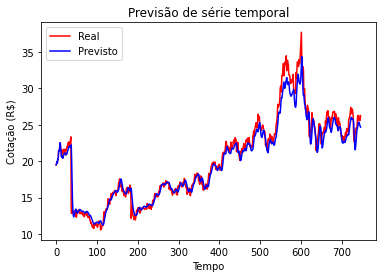

In [194]:
allTargetData = np.vstack((training_set, dataset_test))
training_predicted_PETR4 = regressor.predict(X_train)
training_predicted_PETR4 = sc.inverse_transform(training_predicted_PETR4)
allForecastedData = np.vstack((training_set[0:window], training_predicted_PETR4, predicted_PETR4))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.savefig('predictions_training_test_25_50_32.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [195]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(dataset_test, predicted_PETR4))
print('RMSE:', rmse)

RMSE: 1.2033854764771006


In [196]:
mse = mean_squared_error(dataset_test, predicted_PETR4)
print('MSE:',mse)

MSE: 1.4481366049960183


In [197]:
mape = np.mean(np.abs((dataset_test-predicted_PETR4) /dataset_test)) * 100
print('MAPE:',mape.iloc[0], '%')

MAPE: 3.552292690753358 %


In [198]:
from sklearn.metrics import r2_score
r2 = r2_score(dataset_test,predicted_PETR4)
print('R2:', r2)

R2: 0.9410705903893979


In [199]:
adj_r2 = (1 - (1 - r2) * ((predicted_PETR4.shape[0] - 1) / 
          (predicted_PETR4.shape[0] - predicted_PETR4.shape[1] - 1)))
print('R2Adj:',adj_r2)

R2Adj: 0.9409517810958281


In [200]:
# results = np.array([units1,units2,units3,rmse,mse,mape.iloc[0],r2,adj_r2]) 

In [201]:
data = pd.array([units1,units2,units3,rmse,mse,mape.iloc[0],r2,adj_r2])

In [202]:
results = np.column_stack((results, data))

In [203]:
print(results)

[[ 50.          50.          50.          50.          50.
   50.          50.          50.          50.        ]
 [ 60.          60.          60.          80.          80.
   80.         100.         100.         100.        ]
 [ 30.          50.          70.          30.          50.
   70.          30.          50.          70.        ]
 [  1.9064291    2.18685944   2.510694     2.28369422   1.46212484
    2.36646655   1.98960462   2.20597159   1.20338548]
 [  3.63447192   4.78235419   6.30358437   5.2152593    2.13780905
    5.60016395   3.95852655   4.86631064   1.4481366 ]
 [  5.86744474   6.98682674   8.22642649   6.95480879   4.32661015
    7.65246645   6.33045414   6.85554608   3.55229269]
 [  0.85210146   0.80539038   0.74348656   0.78777406   0.91300557
    0.77211103   0.83891462   0.80197392   0.94107059]
 [  0.85180328   0.80499803   0.74296939   0.78734619   0.91283017
    0.77165158   0.83858985   0.80157468   0.94095178]]


In [204]:
my_df = pd.DataFrame(results)

In [205]:
my_df.to_csv('results_LSTM6.csv', index=False)